# Overview

We are going to implement a Arena leaderboard with SemScore.

In [1]:
%%capture
!pip install transformers==4.38.2
!pip install accelerate==0.27.2
!pip install datasets==2.18.0
!pip install peft==0.9.0
!pip install bitsandbytes==0.42.0
# !pip install sentence-transformers==2.5.1

In [2]:
import os
import torch
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["MODEL_NAME"] = ""
os.environ["DATASET"]="lmsys/chatbot_arena_conversations"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Loading the Dataset

In [3]:
from datasets import load_dataset

dataset=load_dataset(os.getenv("DATASET"), split="train")
dataset

Generating train split:   0%|          | 0/33000 [00:00<?, ? examples/s]

Dataset({
    features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn', 'anony', 'language', 'tstamp', 'openai_moderation', 'toxic_chat_tag'],
    num_rows: 33000
})

# Conversations per Model

In [4]:
model_conv_count={}
for d in dataset:
    for k in ["model_a","model_b"]:
        model=d[k]
        if not model in model_conv_count:
            model_conv_count[model]=1
        else:
            model_conv_count[model]+=1
model_conv_count

{'chatglm-6b': 3322,
 'koala-13b': 5573,
 'oasst-pythia-12b': 4890,
 'alpaca-13b': 4453,
 'vicuna-13b': 5931,
 'dolly-v2-12b': 2786,
 'stablelm-tuned-alpha-7b': 2795,
 'llama-13b': 2009,
 'fastchat-t5-3b': 3210,
 'gpt-3.5-turbo': 4654,
 'gpt-4': 4217,
 'RWKV-4-Raven-14B': 3682,
 'claude-v1': 3927,
 'mpt-7b-chat': 2854,
 'palm-2': 2955,
 'claude-instant-v1': 2626,
 'vicuna-7b': 2869,
 'wizardlm-13b': 1116,
 'gpt4all-13b-snoozy': 1097,
 'guanaco-33b': 1034}

# Extracting Conversations that GPT4 Gave One of the Two Answers

In [5]:
from tqdm import tqdm

reference_model="gpt-4"
answers={}

for judgement in tqdm(dataset):
    models_involved=judgement["model_a"]+judgement["model_b"]
    if not reference_model in models_involved:
        continue
    # get answers for GPT-4 and other model
    reference_label, other_label=("a","b")  if judgement["model_a"]==reference_model else("b", "a")
    answers_ref=[msg["content"] for msg in judgement[f"conversation_{reference_label}"] if msg["role"]=="assistant"]
    answers_other=[msg["content"] for msg in judgement[f"conversation_{other_label}"] if msg["role"]=="assistant"]
    
    # store answers in answes dict
    other_model=judgement[f"model_{other_label}"]
    if not other_model in answers:
        answers[other_model]=dict(answers_model=[], answers_ref=[])
    answers[other_model]["answers_model"].extend(answers_other)
    answers[other_model]["answers_ref"].extend(answers_ref)


100%|██████████| 33000/33000 [00:10<00:00, 3216.33it/s]


In [6]:
import pandas as pd

data={"Model": answers.keys(), 'num_answers':[len(answers[m]["answers_model"]) for m in answers]}

df=pd.DataFrame(data)
df=df.sort_values(by=["num_answers"], ascending=False)
df.head()

,Model,num_answers
0,vicuna-13b,448
3,gpt-3.5-turbo,436
2,koala-13b,417
1,oasst-pythia-12b,395
10,claude-v1,366


In [7]:
from transformers import AutoModel

model=AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to('cuda')
model.max_seq_length=5000
model.eval()
model.device

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


device(type='cuda', index=0)

In [8]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

def emb_mean_pooling(embedding, attention_mask):
    token_embeddings=embedding[0]
    input_mask_expanded=attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings*input_mask_expanded,1)/torch.clamp(input_mask_expanded.sum(1),min=1e-9)


def get_embeddings(sentences, b_size=8):
    embeddings=torch.tensor([], device='cuda')
    batches=[sentences[i:i+b_size] for i in range(0, len(sentences), b_size)]
    
    for s in batches:
        encoded_input=tokenizer(s, padding=True, truncation=True, return_tensors='pt').to('cuda')
        with torch.no_grad():
            output=model(**encoded_input)
        batch_embeddings=emb_mean_pooling(output, encoded_input['attention_mask'])
        embeddings=torch.cat((embeddings, batch_embeddings), dim=0)
    return embeddings


def nn_cos(emd1,emd2):
    cos=nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(emd_ans, emd_ref).tolist()


emd_ans=get_embeddings([answers["vicuna-13b"]["answers_model"][6]])
emd_ref=get_embeddings([answers["vicuna-13b"]["answers_ref"][6]])

print(nn_cos(emd_ans, emd_ref)[0])

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

0.9575577974319458


In [9]:
from statistics import mean

emd_ans=get_embeddings(answers["vicuna-13b"]["answers_model"])
emd_ref=get_embeddings(answers["vicuna-13b"]["answers_ref"])


print(mean(nn_cos(emd_ans, emd_ref)))

0.769672397262184


# Calculating Similarity for all Answers

In [10]:
ms_name=list(answers.keys())
list_similarities=[]


for m_name in tqdm(ms_name):
    emd_ans=get_embeddings(answers[m_name]["answers_model"])
    emd_ref=get_embeddings(answers[m_name]["answers_ref"])
    similarities=nn_cos(emd_ans, emd_ref)
    list_similarities.append(mean(similarities))

100%|██████████| 19/19 [02:25<00:00,  7.66s/it]


In [11]:
data={
    "Model": answers.keys(),
    "num_answers": [len(answers[m]["answers_model"]) for m in answers],
    "SemScore": list_similarities,
}

df=pd.DataFrame(data)
df=df.sort_values(by=['SemScore'], ascending=False)
df

,Model,num_answers,SemScore
17,wizardlm-13b,73,0.813826
10,claude-v1,366,0.801175
3,gpt-3.5-turbo,436,0.799797
15,claude-instant-v1,191,0.773934
0,vicuna-13b,448,0.769672
18,guanaco-33b,90,0.765226
14,vicuna-7b,249,0.740022
2,koala-13b,417,0.711215
5,fastchat-t5-3b,258,0.709203
16,gpt4all-13b-snoozy,80,0.708363


In [12]:
# hard coded elo ratings, fetched 02/2024
# Original https://github.com/geronimi73/semscore/blob/main/nb_blog_part1_arena-leaderboard.ipynb
# Adapted by: Aisuko

elo_ratings_raw = \
"""1	gpt-4-turbo	1250
2	bard-jan-24-gemini-pro	1214
3	gpt-4-0314	1189
4	gpt-4-0613	1161
5	mistral-medium	1150
6	claude-1	1150
7	claude-2.0	1131
8	mixtral-8x7b-instruct-v0.1	1122
9	gemini-pro-dev-api	1122
10	claude-2.1	1119
11	gpt-3.5-turbo-0613	1117
12	gemini-pro	1114
13	yi-34b-chat	1112
14	claude-instant-1	1110
15	wizardlm-70b	1106
16	tulu-2-dpo-70b	1105
17	gpt-3.5-turbo-0314	1104
18	deepseek-llm-67b-chat	1099
19	vicuna-33b	1094
20	starling-lm-7b-alpha	1089
21	llama-2-70b-chat	1081
22	llama2-70b-steerlm-chat	1078
23	openchat-3.5	1077
24	openhermes-2.5-mistral-7b	1076
25	pplx-70b-online	1074
26	gpt-3.5-turbo-1106	1072
27	solar-10.7b-instruct-v1.0	1065
28	dolphin-2.2.1-mistral-7b	1064
29	wizardlm-13b	1058
30	zephyr-7b-beta	1050
31	mpt-30b-chat	1043
32	codellama-34b-instruct	1042
33	vicuna-13b	1040
34	llama-2-13b-chat	1039
35	zephyr-7b-alpha	1037
36	pplx-7b-online	1036
37	qwen-14b-chat	1034
38	falcon-180b-chat	1032
39	guanaco-33b	1031
40	llama-2-7b-chat	1021
41	stripedhyena-nous-7b	1017
42	mistral-7b-instruct	1010
43	palm-2	1005
44	vicuna-7b	1005
45	koala-13b	965
46	chatglm3-6b	960
47	gpt4all-13b-snoozy	937
48	mpt-7b-chat	930
49	chatglm2-6b	929
50	RWKV-4-Raven-14B	924
51	alpaca-13b	904
52	oasst-pythia-12b	896
53	chatglm-6b	883
54	fastchat-t5-3b	874
55	stablelm-tuned-alpha-7b	844
56	dolly-v2-12b	822
57	llama-13b	800"""


model_elo=[]

def get_dashboard():
    elo_ratings={}

    for line in elo_ratings_raw.split("\n"):
        line_split=line.split("\t")
        m=line_split[1]
        elo=line_split[2]
        elo_ratings[m]=elo

    model_map_elo={
        "claude-v1":"claude-1",
        "gpt-3.5-turbo": "gpt-3.5-turbo-0613",
        "claude-instant-v1": "claude-instant-1"
    }

    for m in ms_name:
        model_elo_name= m if not m in model_map_elo else model_map_elo[m]
        elo=elo_ratings[model_elo_name] if model_elo_name in elo_ratings else None
        model_elo.append(int(elo))

    data={
        'Model': answers.keys(),
        'num_answers': [len(answers[m]["answers_model"]) for m in answers],
        'ELO': model_elo,
        'SemScore': list_similarities,
        'rank_ELO': [sorted(model_elo, reverse=True).index(x)+1 for x in model_elo],
        'rank_SemScore': [sorted(list_similarities, reverse=True).index(x)+1 for x in list_similarities]
    }
    return data

df=pd.DataFrame(get_dashboard())
df=df.sort_values(by=['rank_SemScore'], ascending=True)
df

,Model,num_answers,ELO,SemScore,rank_ELO,rank_SemScore
17,wizardlm-13b,73,1058,0.813826,4,1
10,claude-v1,366,1150,0.801175,1,2
3,gpt-3.5-turbo,436,1117,0.799797,2,3
15,claude-instant-v1,191,1110,0.773934,3,4
0,vicuna-13b,448,1040,0.769672,5,5
18,guanaco-33b,90,1031,0.765226,6,6
14,vicuna-7b,249,1005,0.740022,7,7
2,koala-13b,417,965,0.711215,9,8
5,fastchat-t5-3b,258,874,0.709203,16,9
16,gpt4all-13b-snoozy,80,937,0.708363,10,10


# Visualization

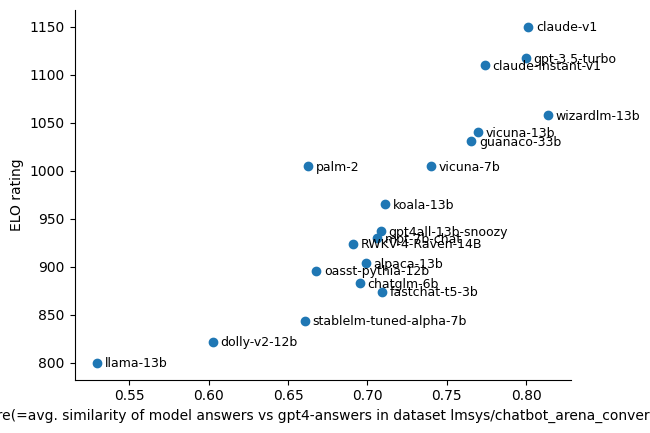

In [13]:
import matplotlib.pyplot as plt

plt.scatter(list_similarities, model_elo)
plt.xlabel('SemScore(=avg. similarity of model answers vs gpt4-answers in dataset lmsys/chatbot_arena_conversations)')
plt.ylabel('ELO rating')

for i, m_name in enumerate(ms_name):
    plt.text(list_similarities[i]+0.005, model_elo[i]-8, m_name, fontsize=9, ha='left', va='bottom')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [14]:
pcc=df['ELO'].corr(df['SemScore'])
print(f"Pearson Correction Coefficient between 'sim' and 'elo': {pcc}")

Pearson Correction Coefficient between 'sim' and 'elo': 0.871734551247602


In [15]:
# low sample models
[m for m in answers if len(answers[m]["answers_model"])<100]

['gpt4all-13b-snoozy', 'wizardlm-13b', 'guanaco-33b']

# Acknowledge

* https://medium.com/@geronimo7/semscore-evaluating-llms-with-semantic-similarity-2abf5c2fadb9
* https://github.com/geronimi73/semscore/blob/main/nb_blog_part1_arena-leaderboard.ipynb
* https://github.com/geronimi73/semscore/blob/main/semscore.py
* https://www.sbert.net/docs/pretrained_models.html
* https://www.kaggle.com/code/aisuko/semantic-search